# NHL: Conner McDavid Predictions

1. At what age will Connor McDavid’s points-per-game (points in hockey are assists + goals) most likely peak?
2. What is the best estimate for Connor McDavid’s points-per-game in his peak season? 
3. What is the best estimate for Connor McDavid’s points-per-game in the 2027 season? 
4. Having completed that, what would be a different question that you’d like to interrogate this data towards? (Please just provide the angle / question you think might be interesting and potentially fruitful. You should not dive into the particular analysis you come up with. Just write up for us your thoughts on some interesting topic you’d pursue with the attached data.)

In [6]:
%reload_ext watermark
%watermark -a Jonathan.Ma -v -m -p numpy,scipy,pandas -g

Jonathan.Ma 

CPython 3.5.2
IPython 5.1.0

numpy 1.11.1
scipy 0.18.0
pandas 0.18.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 2
interpreter: 64bit
Git hash   :


# Loading in the libraries for analysis.

In [112]:
# Getting data into right structure
import os
import numpy as np
import pandas as pd
import datetime as date

# Split test train
from sklearn.cross_validation import train_test_split

# Outlier detection
from sklearn import svm

# Clustering
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn import manifold, decomposition, ensemble, discriminant_analysis, random_projection
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD, PCA

# Visualizing
import seaborn as sns
import matplotlib.pyplot as plt
import bokeh.charts
from bokeh.plotting import figure, ColumnDataSource, show
from bokeh.models import HoverTool
from bokeh.io import output_notebook

#regression line import formula api as alias smf
import statsmodels.formula.api as smf

%matplotlib inline
output_notebook()

import warnings
warnings.filterwarnings('ignore')

Loading BokehJS ...

# Loading & Cleaning up the dataset

In [113]:
# read csv file, parse date from date of birth column
DIR = '/Users/JMa/Learn/NHL/'
filename = os.path.join(DIR, 'data/raw/NHL_Forwards_v01.csv')
df = pd.read_csv(filename, parse_dates = ['DateOfBirth'])

#add Conner McDavid stats from http://oilers.nhl.com/club/player.htm?id=8478402
col = df.columns
df_CM = pd.DataFrame([[231200, 'CONNER MCDAVID',2016, 'Edmonton Oilers', 45, 16/45, 32/45, 48/45, pd.to_datetime('1997-01-13', format='%Y-%m-%d')]], columns =col)
df = df.append(df_CM, ignore_index=True)

# get age during season from birthdate; add Age, Goals, Assists, Birth Month (BM) column
df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth'], format='%y-%m-%d')    # 1
season = pd.to_datetime(df['SeasonEnding'], format='%Y')
df['DateOfBirth'] = df['DateOfBirth'].where(df['DateOfBirth'] < season, df['DateOfBirth'] -  np.timedelta64(100, 'Y'))   # 2
df['Age'] = (season - df['DateOfBirth']).astype('<m8[Y]') 
df['BM'] = df.DateOfBirth.map(lambda x: x.strftime('%m')).astype('int')

# get total goals and assist numbers
df['Goals'] = df['GoalsPerGame']*df['GamesPlayed']
df['Assists'] = df['AssistsPerGame']*df['GamesPlayed']

# Get if transfer, Seasons Played, Seasons Played on Particular Team
df['one'] = 1.0
tmp = df.groupby(['PlayerId', 'SeasonEnding']).cumsum()
tmp.loc[tmp.one == 1, 'One'] = 0
tmp.loc[tmp.one == 2, 'One'] = 1
df['Transfer'] = tmp.One
df.drop(['one'], axis=1)
tmp = df.groupby(['PlayerId', 'Transfer']).cumsum()
df['SeasonsPlayed'] = tmp.one
df['Shift'] = df.SeasonsPlayed.shift(1)
df.loc[df.Transfer == 1, 'SeasonsPlayed'] = df.Shift
tmp = df.groupby(['PlayerId', 'Team']).cumsum()
df['SeasonsPlayedOnTeam'] = tmp.one
df['Shift2'] = df.Shift.shift(1)
df.loc[df.Transfer.isnull(), 'SeasonsPlayed'] = df.Shift2
df.loc[df.Transfer.isnull()] = 0.0

In [114]:
df = df.drop(['DateOfBirth'], axis = 1)
df = df.drop(['one', 'Shift', 'Shift2'], axis=1)
df = df.drop_duplicates()

In [115]:
df.describe()


,PlayerId,SeasonEnding,GamesPlayed,GoalsPerGame,AssistsPerGame,TotalPointsPerGame,Age,BM,Goals,Assists,Transfer,SeasonsPlayed,SeasonsPlayedOnTeam
count,9949.000000,9949.000000,9949.000000,9949.000000,9949.000000,9949.000000,9949.000000,9949.000000,9949.000000,9949.000000,9949.000000,9949.000000,9949.00000
mean,13963.149161,2007.955473,45.095487,0.155599,0.221333,0.402401,26.698462,5.989647,8.835461,12.421650,0.083626,4.324153,2.48045
std,16068.621696,20.740724,29.457167,0.138012,0.189207,1.515894,4.576401,3.447783,10.291136,13.746989,0.276841,3.127816,2.03447
min,0.000000,0.000000,0.000000,-0.379747,-0.437500,-0.784810,0.000000,0.000000,-30.000000,-35.000000,0.000000,0.000000,0.00000
25%,8670.000000,2003.000000,16.000000,0.046875,0.076923,0.150000,23.000000,3.000000,1.000000,2.000000,0.000000,2.000000,1.00000
50%,9098.000000,2008.000000,48.000000,0.133333,0.187500,0.333333,26.000000,6.000000,5.000000,8.000000,0.000000,3.000000,2.00000
75%,11744.000000,2012.000000,73.000000,0.237288,0.333333,0.560606,30.000000,9.000000,14.000000,19.000000,0.000000,6.000000,3.00000
max,231299.000000,2016.000000,700.000000,1.000000,1.444444,100.000000,56.000000,12.000000,360.000000,240.000000,1.000000,16.000000,16.00000


In [120]:
#remove outliers and duplicates
df = df[df.TotalPointsPerGame < 60]
df = df[df.GamesPlayed < 100 ]
df = df[df.TotalPointsPerGame > 0]
df = df[df.Age < 45]
df.describe()

,PlayerId,SeasonEnding,GamesPlayed,GoalsPerGame,AssistsPerGame,TotalPointsPerGame,Age,BM,Goals,Assists,Transfer,SeasonsPlayed,SeasonsPlayedOnTeam
count,8716.000000,8716.000000,8716.000000,8716.000000,8716.000000,8716.000000,8716.000000,8716.000000,8716.000000,8716.000000,8716.000000,8716.000000,8716.000000
mean,13363.077100,2008.121156,50.526159,0.177552,0.252525,0.430072,26.939307,6.043483,10.047614,14.149151,0.087884,4.543713,2.604176
std,15607.965446,4.994524,26.142991,0.133032,0.180634,0.273597,4.572999,3.459735,9.671585,13.532639,0.283143,3.166708,2.108650
min,59.000000,2000.000000,1.000000,0.000000,0.000000,0.017857,18.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,8631.000000,2003.000000,26.000000,0.079365,0.116667,0.214286,23.000000,3.000000,2.000000,3.000000,0.000000,2.000000,1.000000
50%,9034.500000,2008.000000,57.000000,0.154388,0.216216,0.378049,26.000000,6.000000,7.000000,10.000000,0.000000,4.000000,2.000000
75%,11417.000000,2012.000000,75.000000,0.250000,0.351351,0.597561,30.000000,9.000000,15.000000,21.000000,0.000000,6.000000,3.000000
max,231299.000000,2016.000000,82.000000,1.000000,1.444444,2.000000,43.000000,12.000000,65.000000,92.000000,1.000000,16.000000,16.000000


# Overview of stats and whats in our dataset. 
1. Average Player played 50.4 games.
2. Average Age is 35.5
3. Most Goals Per Game is 1.0
4. Most Assists Per Game is 1.4
5. Most Total Points Per Game is 2.0

In [3]:
df.corr('pearson')

,PlayerId,SeasonEnding,GamesPlayed,GoalsPerGame,AssistsPerGame,TotalPointsPerGame,Age,BM,Goals,Assists,Transfer,SeasonsPlayed,SeasonsPlayedOnTeam
PlayerId,1.000000,0.102468,-0.131784,-0.110374,-0.119445,-0.132530,-0.135613,-0.006231,-0.148092,-0.156726,-0.016505,-0.260140,-0.159115
SeasonEnding,0.102468,1.000000,-0.018052,-0.013186,-0.036618,-0.030550,-0.031313,0.013905,-0.024721,-0.035427,-0.048749,0.484502,0.271939
GamesPlayed,-0.131784,-0.018052,1.000000,0.309083,0.293979,0.344363,0.154807,0.045412,0.693670,0.690075,-0.321066,0.204890,0.293407
GoalsPerGame,-0.110374,-0.013186,0.309083,1.000000,0.510068,0.823215,0.032011,0.050022,0.783828,0.585526,-0.038984,0.105547,0.216206
AssistsPerGame,-0.119445,-0.036618,0.293979,0.510068,1.000000,0.908183,0.108914,0.072973,0.589344,0.796773,-0.028898,0.153079,0.255996
TotalPointsPerGame,-0.132530,-0.030550,0.344363,0.823215,0.908183,1.000000,0.087464,0.072366,0.770383,0.810715,-0.037880,0.152397,0.274162
Age,-0.135613,-0.031313,0.154807,0.032011,0.108914,0.087464,1.000000,0.102281,0.079268,0.130796,0.072002,0.623031,0.211185
BM,-0.006231,0.013905,0.045412,0.050022,0.072973,0.072366,0.102281,1.000000,0.055892,0.075958,0.002541,0.042311,0.051119
Goals,-0.148092,-0.024721,0.693670,0.783828,0.589344,0.770383,0.079268,0.055892,1.000000,0.830278,-0.201231,0.160247,0.312239
Assists,-0.156726,-0.035427,0.690075,0.585526,0.796773,0.810715,0.130796,0.075958,0.830278,1.000000,-0.197324,0.194604,0.339044


1. High Correlation Between Total Points Per Game (TPPG) and Assists and Goals Per Game, which is expected. 
2. Assists has a greater impact to TPPG than goals, since an assist is awarded to the player or players (maximum of two) who touch the puck prior to the goal, provided no defender plays or possesses the puck in between. Since there will be a greater sample of assists than goals, naturally there will be more weight associated with it. 
3. Close to zero correlation between TPPG and Age and Games Played, most likely some higher order polynomial relationship between the values. Visualization will confirm.

Assuming normal distribution of dataset. 

Note: Pearson’s correlation coefficient is a statistical measure of the strength of a linear relationship between paired data. In a sample it is denoted by r and is by design constrained as follows.

    * Positive values denote positive linear correlation;
    * Negative values denote negative linear correlation;
    * A value of 0 denotes no linear correlation;
    * The closer the value is to 1 or –1, the stronger the linear correlation.


In [4]:
df.corr('spearman')

,PlayerId,SeasonEnding,GamesPlayed,GoalsPerGame,AssistsPerGame,TotalPointsPerGame,Age,BM,Goals,Assists,Transfer,SeasonsPlayed,SeasonsPlayedOnTeam
PlayerId,1.000000,0.200075,-0.218979,-0.209724,-0.248501,-0.250376,-0.190519,-0.015525,-0.261536,-0.289302,-0.011098,-0.304398,-0.156712
SeasonEnding,0.200075,1.000000,-0.028445,-0.008828,-0.033236,-0.024522,-0.037405,0.015569,-0.012859,-0.027622,-0.048165,0.464273,0.238399
GamesPlayed,-0.218979,-0.028445,1.000000,0.391209,0.364817,0.389906,0.155094,0.049418,0.793196,0.797204,-0.303058,0.234870,0.346879
GoalsPerGame,-0.209724,-0.008828,0.391209,1.000000,0.581190,0.841620,0.048505,0.063359,0.820964,0.633356,-0.045802,0.151689,0.221349
AssistsPerGame,-0.248501,-0.033236,0.364817,0.581190,1.000000,0.912624,0.107525,0.074559,0.618109,0.800683,-0.033591,0.179617,0.230848
TotalPointsPerGame,-0.250376,-0.024522,0.389906,0.841620,0.912624,1.000000,0.083638,0.078367,0.759258,0.787122,-0.036317,0.174954,0.239908
Age,-0.190519,-0.037405,0.155094,0.048505,0.107525,0.083638,1.000000,0.099997,0.120616,0.162187,0.079617,0.612176,0.132645
BM,-0.015525,0.015569,0.049418,0.063359,0.074559,0.078367,0.099997,1.000000,0.069843,0.074427,0.002042,0.034023,0.042093
Goals,-0.261536,-0.012859,0.793196,0.820964,0.618109,0.759258,0.120616,0.069843,1.000000,0.883972,-0.214954,0.240388,0.348780
Assists,-0.289302,-0.027622,0.797204,0.633356,0.800683,0.787122,0.162187,0.074427,0.883972,1.000000,-0.213143,0.261388,0.361774


Little difference between Pearson and Spearman coefficents. 

# Visualizing the Data

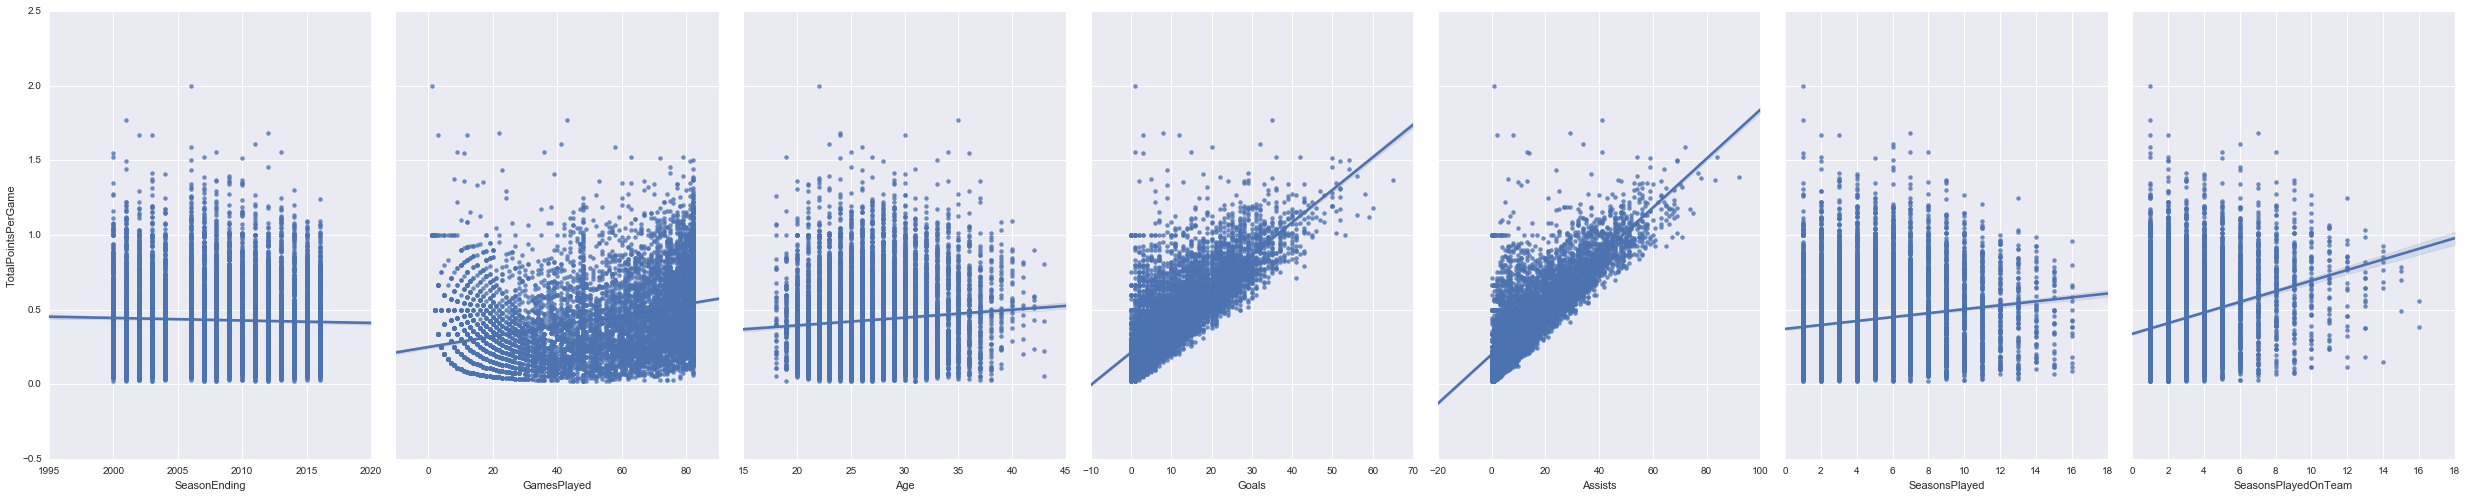

In [5]:
sns.pairplot(df, x_vars=['SeasonEnding','GamesPlayed','Age','Goals', 'Assists', 'SeasonsPlayed', 'SeasonsPlayedOnTeam'], y_vars=['TotalPointsPerGame'], size=7, aspect=0.7, kind='reg')

Visualizing the data and seeing if there are any clear relationships. As expected there is a linear relationship between goals and assists to total points per game, since points in hockey are a combination of goals and assists. Missing data from 2005. It looks like there is a quadratic relationship between age and TPPG, but another visualization should confirm this. Missing data from 2004-2005 season since the NHL had the lockout that year. 

We can confirm correlation with TPPG with a regression line through the data. Goals and assists are positively correlated with TTPG seen by the high slope of the regression line. Age and Games played are only slightly correlated. 

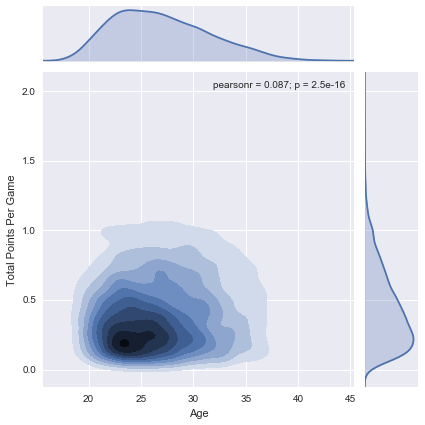

In [6]:
g= sns.jointplot(data=df, x= 'Age', y='TotalPointsPerGame', kind="kde")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("Age", "Total Points Per Game");

We can see here there is definitely more younger players over the years. Mainly between 21 to 27. Average players peak around 23-24 years old, but under 0.5 TPPG.

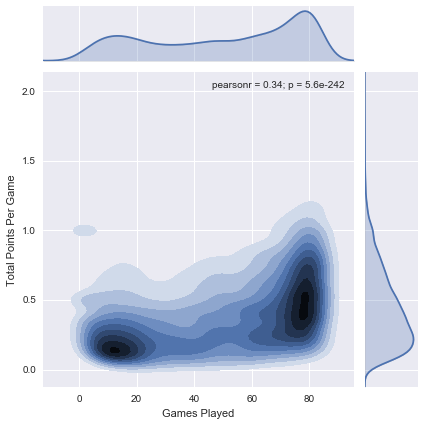

In [7]:
g = sns.jointplot(data=df, x= 'GamesPlayed', y='TotalPointsPerGame', kind="kde")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("Games Played", "Total Points Per Game");

Looks like there are two sets of players. Those that play less than 20 games and those that play over 60 games. 

# Split into two groups at 40 Games Played Threshold

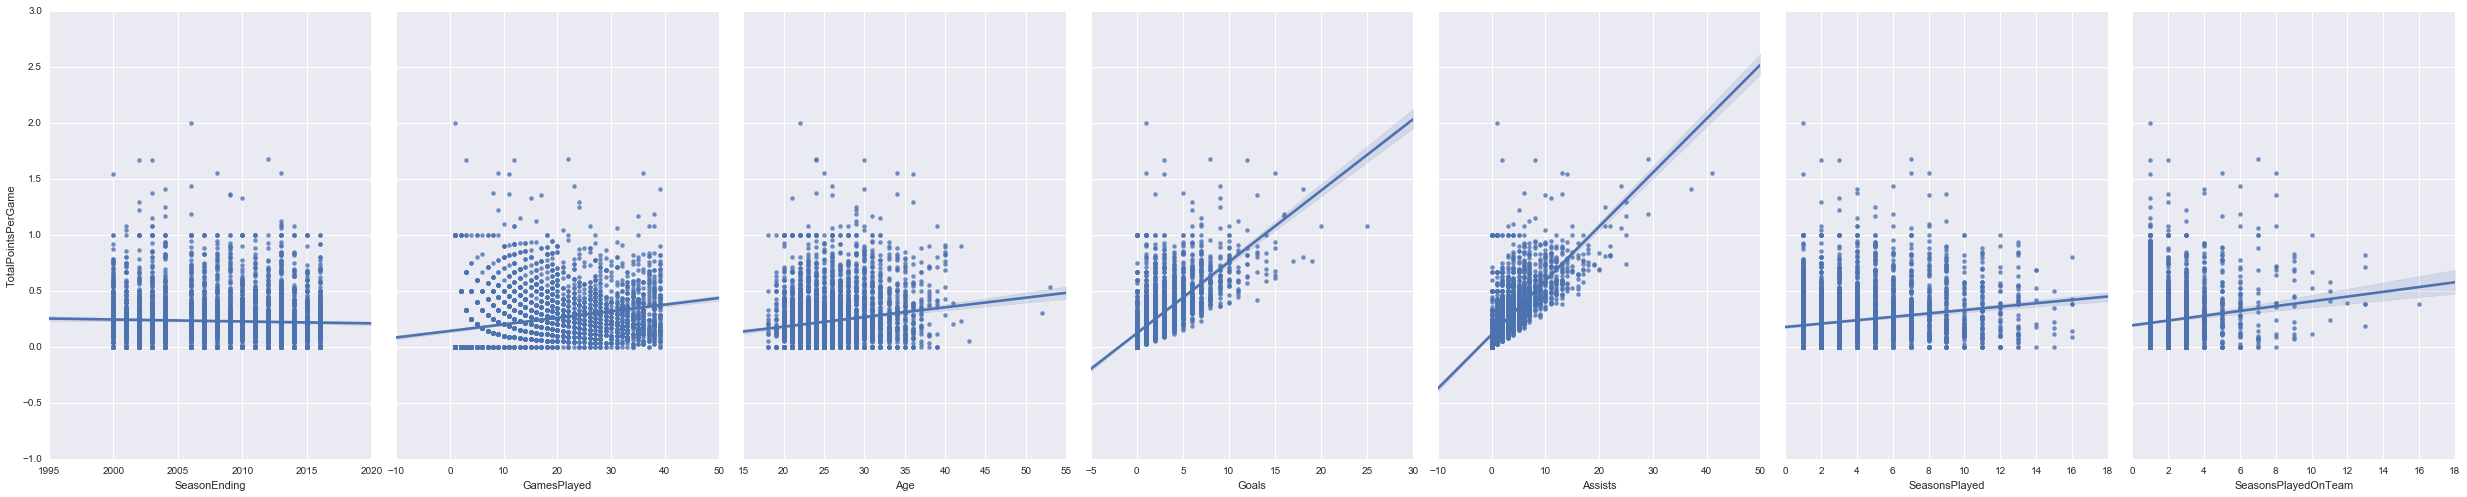

In [11]:
df_20 = df[df.GamesPlayed < 40]
df_40 = df[df.GamesPlayed >= 40]
sns.pairplot(df_20, x_vars=['SeasonEnding','GamesPlayed','Age','Goals', 'Assists', 'SeasonsPlayed', 'SeasonsPlayedOnTeam'], y_vars=['TotalPointsPerGame'], size=7, aspect=0.7, kind='reg')

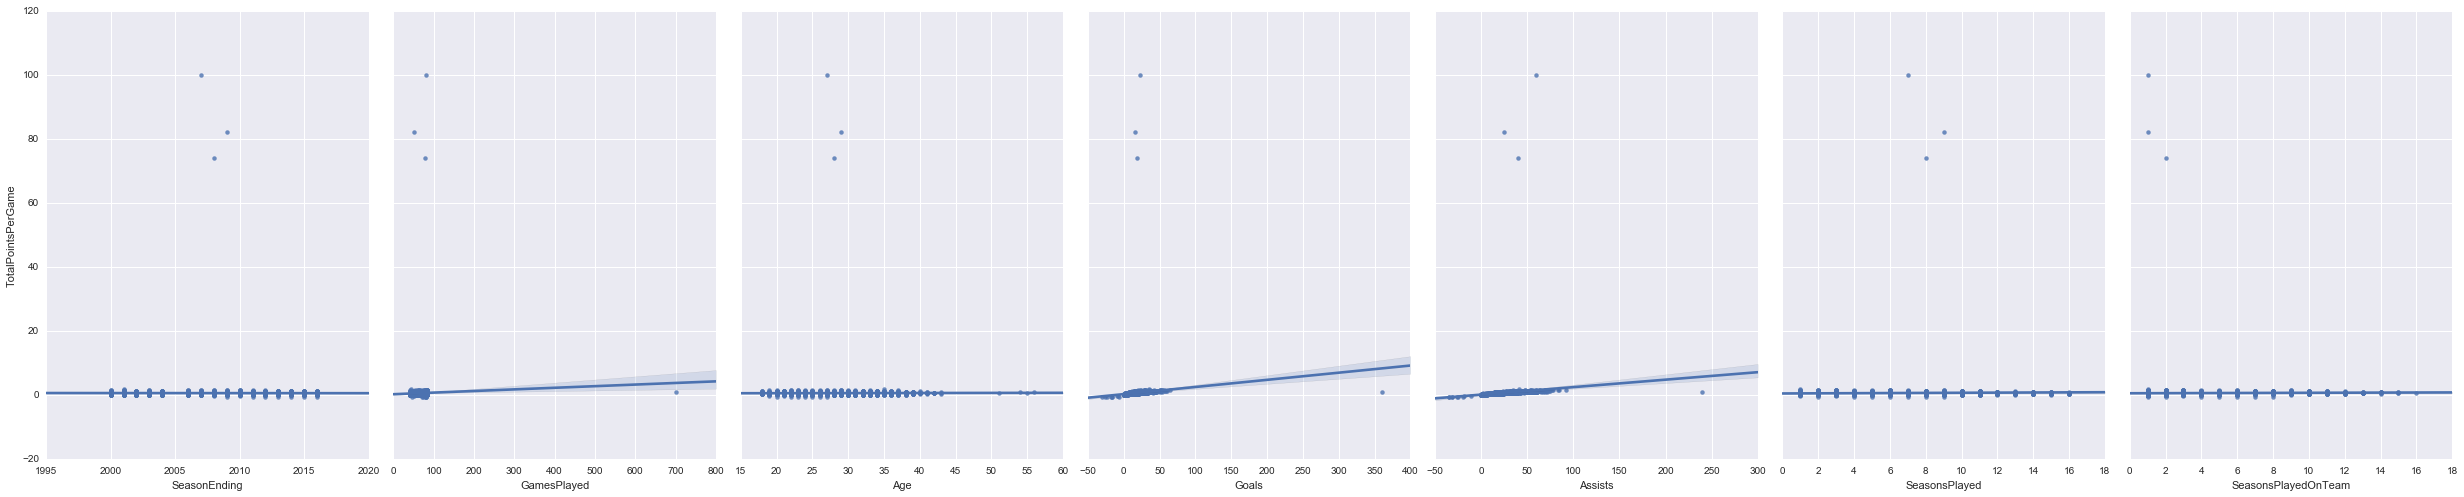

In [7]:
sns.pairplot(df_40, x_vars=['SeasonEnding','GamesPlayed','Age','Goals', 'Assists', 'SeasonsPlayed', 'SeasonsPlayedOnTeam'], y_vars=['TotalPointsPerGame'], size=7, aspect=0.7, kind='reg')

# Analysis

Since there wasn't a clear linear relationship between age and TPPG, another type of analysis must be done. I chose to follow something similar to the fivethirtyeight's CARMELO system. To essentially use the historical data to group players together with t-Distributed Stochastic Neighbor Embedding (t-SNE) and project careers path. The advantage of using t-SNE is to use an unsupervised approach as there was no easy correlation between Age and TPPG. With the hopes that we can infer natural groupings of all NHL players as our best estimate to find out what age Conner McDavid (or any other player) will peak at or what his career will be like. 


Process:
1. Compute the correlation matrix for stats for all players.
2. Use PCA or a truncated SVD to reduce data to fewer dimensions. So in the future when more stats and features of the dataset are added, this approach can still be used. 
3. Applying the t-SNE dimensionality reduction algorithm. Roughly, t-SNE is considered to be useful because of its property to conserve the overall topology of the data, so that neighboring players are mapped to neighboring locations in a two-dimensional space 
4. Visualize and grab players that are closest to Conner McDavid. Calculate how close they were and associate that to a similarity score.  
5. Polynomial Regression to estimate Conner McDavid's future stats. 

Note: Could use other clustering techniques such as k-means or MDS, but visualization is easily seen with t-SNE. Model will get better with more stats and more data from Conner McDavid.

In [63]:
# Set index 
df_final = df_40
y = df_final['TotalPointsPerGame']
df_final = df_final.set_index(['PlayerId', 'Team', 'Name', 'Age'])
df_final = df_final.drop(['GoalsPerGame', 'AssistsPerGame'], axis=1)
df_final.head()

SeasonEnding  \
PlayerId Team                Name               Age                  
75       Tampa Bay Lightning NILS EKMAN         24.0          2001   
         San Jose Sharks     NILS EKMAN         27.0          2004   
                                                29.0          2006   
79       Atlanta Thrashers   JOHAN GARPENLOV    31.0          2000   
89       Phoenix Coyotes     MATHIAS TJARNQVIST 28.0          2008   

                                                      GamesPlayed  \
PlayerId Team                Name               Age                 
75       Tampa Bay Lightning NILS EKMAN         24.0           43   
         San Jose Sharks     NILS EKMAN         27.0           82   
                                                29.0           77   
79       Atlanta Thrashers   JOHAN GARPENLOV    31.0           73   
89       Phoenix Coyotes     MATHIAS TJARNQVIST 28.0           78   

                                                      TotalPointsPerGame  BM  \
PlayerId Team                Name               Age                            
75       Tampa Bay Lightning NILS EKMAN         24.0            0.465116   3   
         San Jose Sharks     NILS EKMAN         27.0            0.670732   3   
                                                29.0            0.740260   3   
79       Atlanta Thrashers   JOHAN GARPENLOV    31.0            0.219178   3   
89       Phoenix Coyotes     MATHIAS TJARNQVIST 28.0            0.141026   4   

                                                      Goals  Assists  \
PlayerId Team                Name               Age                    
75       Tampa Bay Lightning NILS EKMAN         24.0    9.0     11.0   
         San Jose Sharks     NILS EKMAN         27.0   22.0     33.0   
                                                29.0   21.0     36.0   
79       Atlanta Thrashers   JOHAN GARPENLOV    31.0    2.0     14.0   
89       Phoenix Coyotes     MATHIAS TJARNQVIST 28.0    4.0      7.0   

                                                      Transfer  SeasonsPlayed  \
PlayerId Team                Name               Age                             
75       Tampa Bay Lightning NILS EKMAN         24.0       0.0            2.0   
         San Jose Sharks     NILS EKMAN         27.0       0.0            3.0   
                                                29.0       0.0            4.0   
79       Atlanta Thrashers   JOHAN GARPENLOV    31.0       0.0            1.0   
89       Phoenix Coyotes     MATHIAS TJARNQVIST 28.0       0.0            4.0   

                                                      SeasonsPlayedOnTeam  
PlayerId Team                Name               Age                        
75       Tampa Bay Lightning NILS EKMAN         24.0                  2.0  
         San Jose Sharks     NILS EKMAN         27.0                  1.0  
                                                29.0                  2.0  
79       Atlanta Thrashers   JOHAN GARPENLOV    31.0                  1.0  
89       Phoenix Coyotes     MATHIAS TJARNQVIST 28.0                  2.0

# Truncated SVD vs PCA

In general, truncated SVD is used for sparse data and PCA for dense data. But since there are such few features, I wasn't sure which would work better so I tried them both. 

In [64]:
# Total Points Per Game
y = y.as_matrix()

# compute correlation matrix
df_final = df_final.convert_objects(convert_numeric=True)
df_final = df_final.astype(float)
corr_x = df_final.T.corr()
X = corr.as_matrix()

In [65]:
# perform SVD|t-SNE dimensionality reduction 
file = DIR + '/data/processed/SVD3_tsne_clusters.csv'
if os.path.isfile(file):
    # If file is already present. Don't run again
    print('%s already present - Skipping the dimensionality reduction.' % (file))
else:
    X_reduced = TruncatedSVD(n_components=3, random_state=0).fit_transform(X)
    tsne = manifold.TSNE(n_components=2, perplexity=40, verbose=2)
    X_tsne = tsne.fit_transform(X_reduced)

    df_SVD = pd.DataFrame(X_tsne)

    # Match up players via index, save to file
    df_SVD['Name'] = [x[2] for x in df_final.index]
    df_SVD['Team'] = [x[1] for x in df_final.index]
    df_SVD['Age'] = [x[3] for x in df_final.index]

    df_SVD.columns = ['x', 'y', 'Name', 'Team', 'Age']

    # Save data for future analysis. 
    df_SVD.to_csv(file, index=False)

    # confirming it worked for all the data. 
    print('Huzzaaaaa!')

/Users/JMa/Learn/NHL//data/processed/SVD3_tsne_clusters.csv already present - Skipping the dimensionality reduction.


In [13]:
# perform PCA| t-SNE dimensionality reduction  
file = DIR + '/data/processed/PCA3_tsne_clusters.csv'
if os.path.isfile(file):
    # If file is already present. Don't run again
    print('%s already present - Skipping the dimensionality reduction.' % (file))
else:
    X_reduced = PCA(n_components=3).fit_transform(X)
    tsne = manifold.TSNE(n_components=2, perplexity=40, verbose=2)
    X_tsne = tsne.fit_transform(X_reduced)

    df_PCA = pd.DataFrame(X_tsne)
    # Match up players via index, save to file
    df_PCA['Name'] = [x[2] for x in df_final.index]
    df_PCA['Team'] = [x[1] for x in df_final.index]
    df_PCA['Age'] = [x[3] for x in df_final.index]
    df_PCA.columns = ['x', 'y', 'Name', 'Team', 'Age']
    df_PCA.to_csv(file, index=False)

    df_PCA.shape

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 5669
[t-SNE] Computed conditional probabilities for sample 2000 / 5669
[t-SNE] Computed conditional probabilities for sample 3000 / 5669
[t-SNE] Computed conditional probabilities for sample 4000 / 5669
[t-SNE] Computed conditional probabilities for sample 5000 / 5669
[t-SNE] Computed conditional probabilities for sample 5669 / 5669
[t-SNE] Mean sigma: 0.000350
[t-SNE] Iteration 25: error = 1.7095543, gradient norm = 0.0114829
[t-SNE] Iteration 50: error = 1.6565709, gradient norm = 0.0066356
[t-SNE] Iteration 75: error = 1.4221132, gradient norm = 0.0026807
[t-SNE] Iteration 100: error = 1.3566098, gradient norm = 0.0022401
[t-SNE] Error after 100 iterations with early exaggeration: 1.356610
[t-SNE] Iteration 125: error = 1.2422367, gradient norm = 0.0016965
[t-SNE] Iteration 150: error = 1.2052388, gradient norm = 0.0015366
[t-SNE] Iteration 

PCA performed sightly better so using that data to analyze the data. 1.153 vs 1.173 error. 

In [69]:
DIR = '/Users/JMa/Learn/NHL/'
filename = os.path.join(DIR, 'data/processed/SVD3_tsne_clusters.csv')
df_SVD = pd.read_csv(filename)

In [80]:
df = df
df2 = df_SVD
Player = 'CONNER MCDAVID'

comb = pd.merge(df, df2, how='inner', on = ['Name', 'Team', 'Age'])
CM = comb[comb.Name == Player]

# Simliarity score based on how close they are to him. using the distance formala  
comb['SScore'] = 100 - np.sqrt((CM.x.mean() - comb.x)**2 + (CM.y.mean() - comb.y)**2)
comb['Norm_SScore'] =(comb.SScore - comb.SScore.min()) / (comb.SScore.max() - comb.SScore.min())
comb['Standard_SScore'] = (comb.SScore - comb.SScore.mean()) / (comb.SScore.std())

CM = comb[comb.Name == Player]

In [86]:
# Save dataframes 
file = DIR + '/data/processed/comb.csv'
file2 = DIR + '/data/processed/CM.csv'

if os.path.isfile(file):
    # If file is already present. Don't run again
    print('%s, %s already present - Skipping the saving.' % (file, file2))
else:
    comb.to_csv(file, index=False)
    CM.to_csv(file2, index=False)

In [74]:
# Visualize    
def bplot(df1, df2):   
    # Interactive Bokeh plot
    _tools = 'box_zoom,pan,save,resize,reset,tap,wheel_zoom'
    fig = figure(tools=_tools, title='t-SNE of Players', responsive=True,
                 x_axis_label='Component 1', y_axis_label='Component 2')

    source = ColumnDataSource(df1)
    source2 = ColumnDataSource(df2)
    hover = HoverTool()
    hover.tooltips=[('Player, Age, Year','@Name, @Age, @SeasonEnding'),]
    fig.scatter(df1['x'], df1['y'], source=source, size=8, alpha=0.6,
                line_color='grey', fill_color='grey')

    fig.scatter(df2.x, df2.y, source=source2, size=8, alpha=0.6,
                line_color='red', fill_color='red')
    fig.add_tools(hover)

    show(fig)
    

bplot(comb, CM)

# Grab 12 players that are closest to Conner McDavid. 


In [92]:
comb = comb.sort('SScore')
sim = comb[comb['SScore'] > 99.74]
# table of players that are similar to Conner
print((sim['Name']))

3691            RYAN SMYTH
5766        DENIS PEDERSON
3006          TIM CONNOLLY
2400          JOCHEN HECHT
5198          PATRICK KANE
3505         KEITH TKACHUK
3751        STEVE SULLIVAN
2354        ALEXEI KOVALEV
3721         CORY STILLMAN
373     MARIUSZ CZERKAWSKI
4791            JEFF COWAN
8756        CONNER MCDAVID
Name: Name, dtype: object


In [93]:
sim.describe()

,PlayerId,SeasonEnding,GamesPlayed,GoalsPerGame,AssistsPerGame,TotalPointsPerGame,Age,BM,Goals,Assists,Transfer,SeasonsPlayed,SeasonsPlayedOnTeam,x,y,SScore,Norm_SScore,Standard_SScore
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.0,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,26913.666667,2007.583333,54.750000,0.257623,0.437268,0.694891,28.750000,5.916667,15.083333,24.916667,0.0,5.916667,3.833333,-2.844950,8.259260,99.855267,0.993132,2.136964
std,64371.548579,5.632024,15.274012,0.154732,0.235013,0.360583,5.136766,3.704011,11.040902,15.535638,0.0,4.337120,3.325749,0.136146,0.096262,0.087489,0.004152,0.016849
min,1467.000000,2000.000000,41.000000,0.042553,0.021739,0.195652,18.000000,1.000000,2.000000,1.000000,0.0,1.000000,1.000000,-3.063785,8.069807,99.741243,0.987720,2.115004
25%,8749.750000,2002.500000,44.500000,0.113805,0.223404,0.292553,26.750000,2.750000,5.000000,10.500000,0.0,1.750000,1.000000,-2.904507,8.213682,99.776916,0.989413,2.121875
50%,8891.000000,2008.000000,47.000000,0.250585,0.499716,0.792683,28.000000,5.500000,13.500000,27.000000,0.0,6.000000,2.000000,-2.833552,8.259155,99.872760,0.993962,2.140332
75%,9175.250000,2013.000000,66.250000,0.377426,0.656571,0.934475,33.250000,9.000000,23.750000,36.250000,0.0,8.250000,6.250000,-2.740082,8.349729,99.916080,0.996018,2.148675
max,231200.000000,2016.000000,82.000000,0.489362,0.711111,1.170213,36.000000,12.000000,35.000000,48.000000,0.0,13.000000,10.000000,-2.633713,8.372726,100.000000,1.000000,2.164837


Interesting note: Conner McDavid played like a 27 year old even though he was only 18. 

# Interactive Bokeh plot of t-SNE

In [94]:
tmp = sim

_tools = 'box_zoom,pan,save,resize,reset,tap,wheel_zoom'
fig = figure(tools=_tools, title='t-SNE of Players', responsive=True,
             x_axis_label='Component 1', y_axis_label='Component 2')

source = ColumnDataSource(tmp)
source2 = ColumnDataSource(CM)
hover = HoverTool()
hover.tooltips=[('Player, Age, % Similar','@Name, @Age, @SScore%'),]
fig.scatter(tmp['x'], tmp['y'], source=source, size=8, alpha=0.6,
            line_color='grey', fill_color='grey')

fig.scatter(CM.x, CM.y, source=source2, size=8, alpha=0.6,
            line_color='blue', fill_color='blue')
fig.add_tools(hover)

show(fig)


# Grab those players similar to Conner McDavid, plot their full stats. 

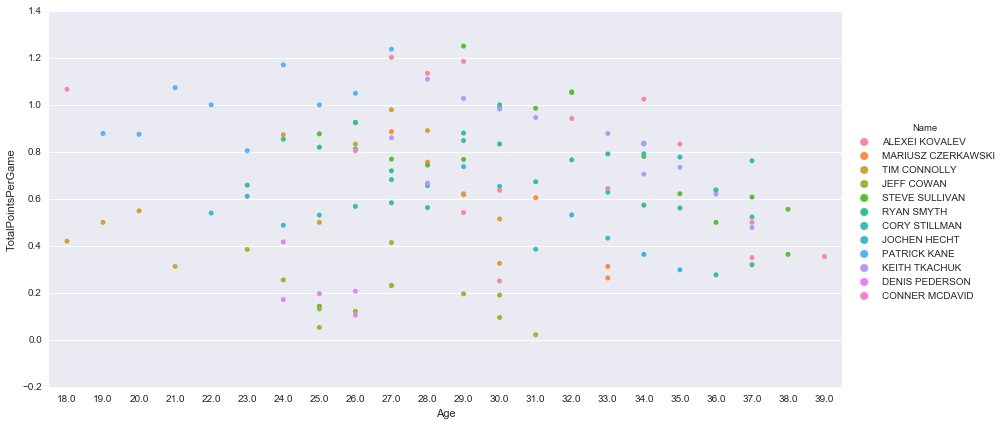

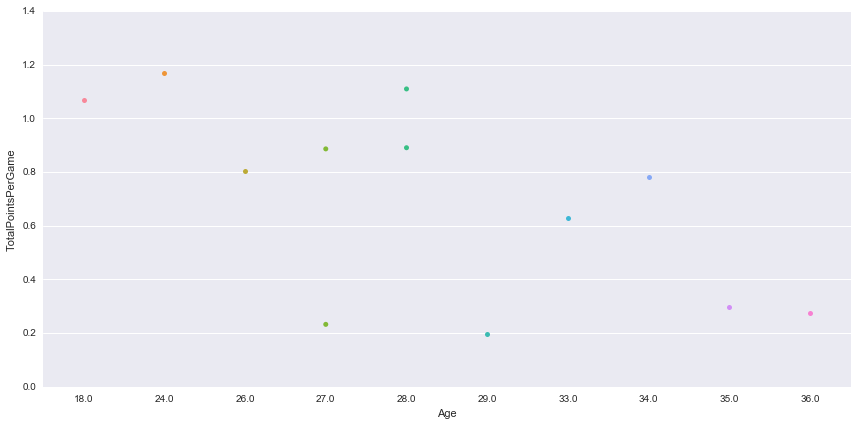

In [95]:
name = sim['Name']
age = sim['Age']
df_sim = comb.loc[comb['Name'].isin(name)]
sns.factorplot(data=df_sim, x='Age', y='TotalPointsPerGame', hue='Name', size=6, aspect=2, kind ='strip')
sns.factorplot(data=sim, x='Age', y='TotalPointsPerGame', size=6, aspect=2, kind ='strip')

#sns.pairplot(sim, x_vars=['Age'], y_vars=['logTPPG'], size=7, aspect=0.7, kind='reg')

# Interactive Age vs Total Points Per Game

In [96]:
tmp = df_sim

_tools = 'box_zoom,pan,save,resize,reset,tap,wheel_zoom'
fig = figure(tools=_tools, title='Age vs Total Points Per Game', responsive=True,
             x_axis_label='Age', y_axis_label='Total Points Per Game')

source = ColumnDataSource(tmp)
source2 = ColumnDataSource(CM)
hover = HoverTool()
hover.tooltips=[('Player, Age, % Similar','@Name, @Age, @SScore%'),]
fig.scatter(tmp['Age'], tmp['TotalPointsPerGame'], source=source, size=8, alpha=0.6,
            line_color='grey', fill_color = 'white')

fig.scatter(CM.Age, CM.TotalPointsPerGame, source=source2, size=8, alpha=0.6,
            line_color='blue', fill_color='blue')
fig.add_tools(hover)

show(fig)

# Prediction
Use those player stats to predict Conner's
    1. reg1: Linear for comparison
    2. reg2: What I think the distribution should be. 
    3. reg3: Maybe to incorporate the sophmore slump?

# Model 1: Just using Player's most simliar seasons to Conner's Rookie Season

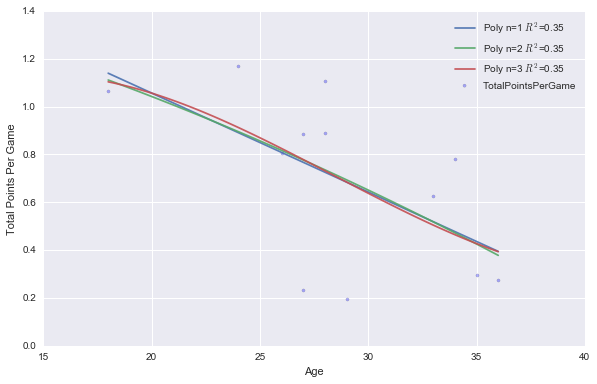

In [97]:
reg11 = smf.ols('TotalPointsPerGame ~ Age', data=sim).fit()
reg21 = smf.ols('TotalPointsPerGame ~ Age + I(Age **2)', data=sim).fit()
reg31 = smf.ols('TotalPointsPerGame ~ Age + I(Age **2) + I(Age **3)', data=sim).fit()

plt.figure(figsize=(6 * 1.618, 6))
plt.scatter(sim.Age, sim.TotalPointsPerGame, s=10, alpha=0.3)
plt.xlabel('Age')
plt.ylabel('Total Points Per Game')

x = pd.DataFrame({'Age': np.linspace(sim.Age.min(), sim.Age.max(), 100)})

plt.plot(x, reg11.predict(x), label='Poly n=1 $R^2$=%.2f' % reg11.rsquared, alpha=0.9)
plt.plot(x, reg21.predict(x), label='Poly n=2 $R^2$=%.2f' % reg21.rsquared, alpha=0.9)
plt.plot(x, reg31.predict(x), label='Poly n=3 $R^2$=%.2f' % reg31.rsquared, alpha=0.9)
plt.legend()

In [98]:
reg31.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     TotalPointsPerGame   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     1.434
Date:                Tue, 06 Sep 2016   Prob (F-statistic):              0.303
Time:                        15:35:27   Log-Likelihood:                -1.6832
No. Observations:                  12   AIC:                             11.37
Df Residuals:                       8   BIC:                             13.31
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       0.0181     16.854      0.001      0.999       -38.847    38.883
Age             0.1678      1.996      0.084      0.935        -4.435     4.770
I(Age ** 2)    -0.0076      0.076     -0.099      0.923        -0.183     0.168
I(Age ** 3)  8.888e-05      0.001      0.094      0.927        -0.002     0.002
==============================================================================
Omnibus:                        1.588   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.452   Jarque-Bera (JB):                1.019
Skew:                          -0.674   Prob(JB):                        0.601
Kurtosis:                       2.530   Cond. No.                     4.91e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.91e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [99]:
# B + Age(AgeC) + I(Age(Age2C) **2)
B, AgeC = reg11.params
B, AgeC, Age2C = reg21.params
B, AgeC, Age2C, Age3C = reg31.params

check1 = False
check2 = False
check3 = True
model1 = []

Age = range(19,32)

if check1 is True:
    for age in Age:
        y = B + AgeC*(age) + (Age2C*((age**2)))
        print('When Conner is Age %d, his TPPG will be: %s' % (age, y))
        model1.append(y)
elif check2 is True:
    for age in Age:
        y = B + AgeC*(age) + (Age2C*((age**2)))
        print('When Conner is Age %d, his TPPG will be: %s' % (age, y))
        model1.append(y)
elif check3 is True:
    for age in Age:
        y = B + AgeC*(age) + (Age2C*((age**2))) + (Age3C*((age**3)))
        print('When Conner is Age %d, his TPPG will be: %s' % (age, y))
        model1.append(y)        

When Conner is Age 19, his TPPG will be: 1.08274586959
When Conner is Age 20, his TPPG will be: 1.05669085147
When Conner is Age 21, his TPPG will be: 1.02616005061
When Conner is Age 22, his TPPG will be: 0.991686734508
When Conner is Age 23, his TPPG will be: 0.953804170638
When Conner is Age 24, his TPPG will be: 0.913045626486
When Conner is Age 25, his TPPG will be: 0.869944369536
When Conner is Age 26, his TPPG will be: 0.82503366727
When Conner is Age 27, his TPPG will be: 0.778846787173
When Conner is Age 28, his TPPG will be: 0.731916996728
When Conner is Age 29, his TPPG will be: 0.684777563419
When Conner is Age 30, his TPPG will be: 0.637961754728
When Conner is Age 31, his TPPG will be: 0.592002838141


# Model 2: Using all Historical Data from Players similar to Conner McDavid

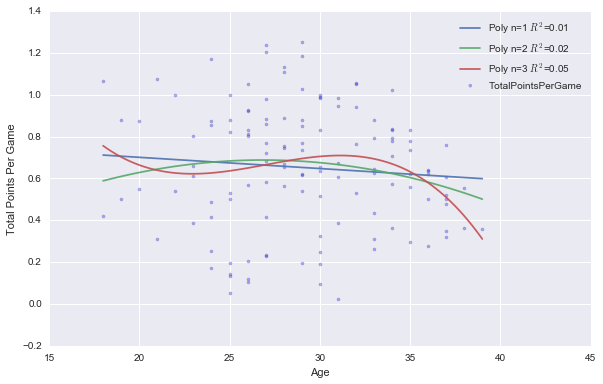

In [100]:
reg1 = smf.ols('TotalPointsPerGame ~ Age', data=df_sim).fit()
reg2 = smf.ols('TotalPointsPerGame ~ Age + I(Age **2)', data=df_sim).fit()
reg3 = smf.ols('TotalPointsPerGame ~ Age + I(Age **2) + I(Age **3)', data=df_sim).fit()

plt.figure(figsize=(6 * 1.618, 6))
plt.scatter(df_sim.Age, df_sim.TotalPointsPerGame, s=10, alpha=0.3)
plt.xlabel('Age')
plt.ylabel('Total Points Per Game')

x = pd.DataFrame({'Age': np.linspace(df_sim.Age.min(), df_sim.Age.max(), 100)})

plt.plot(x, reg1.predict(x), label='Poly n=1 $R^2$=%.2f' % reg1.rsquared, alpha=0.9)
plt.plot(x, reg2.predict(x), label='Poly n=2 $R^2$=%.2f' % reg2.rsquared, alpha=0.9)
plt.plot(x, reg3.predict(x), label='Poly n=3 $R^2$=%.2f' % reg3.rsquared, alpha=0.9)
plt.legend()

In [101]:
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     TotalPointsPerGame   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.424
Date:                Tue, 06 Sep 2016   Prob (F-statistic):              0.245
Time:                        15:35:29   Log-Likelihood:                -22.681
No. Observations:                 129   AIC:                             51.36
Df Residuals:                     126   BIC:                             59.94
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      -0.2265      0.780     -0.290      0.772        -1.770     1.317
Age             0.0681      0.054      1.249      0.214        -0.040     0.176
I(Age ** 2)    -0.0013      0.001     -1.354      0.178        -0.003     0.001
==============================================================================
Omnibus:                        4.446   Durbin-Watson:                   1.782
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                3.545
Skew:                          -0.292   Prob(JB):                        0.170
Kurtosis:                       2.436   Cond. No.                     2.78e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.78e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [102]:
# B + Age(AgeC) + I(Age(Age2C) **2)
B, AgeC = reg1.params
B, AgeC, Age2C = reg2.params
B, AgeC, Age2C, Age3C = reg3.params

check1 = False
check2 = False
check3 = True
model1 = []

Age = range(19,32)

if check1 is True:
    for age in Age:
        y = B + AgeC*(age) + (Age2C*((age**2)))
        print('When Conner is Age %d, his TPPG will be: %s' % (age, y))
        model1.append(y)
elif check2 is True:
    for age in Age:
        y = B + AgeC*(age) + (Age2C*((age**2)))
        print('When Conner is Age %d, his TPPG will be: %s' % (age, y))
        model1.append(y)
elif check3 is True:
    for age in Age:
        y = B + AgeC*(age) + (Age2C*((age**2))) + (Age3C*((age**3)))
        print('When Conner is Age %d, his TPPG will be: %s' % (age, y))
        model1.append(y)  
    

When Conner is Age 19, his TPPG will be: 0.702238499427
When Conner is Age 20, his TPPG will be: 0.663923595628
When Conner is Age 21, his TPPG will be: 0.639062330001
When Conner is Age 22, his TPPG will be: 0.625740964153
When Conner is Age 23, his TPPG will be: 0.622045759687
When Conner is Age 24, his TPPG will be: 0.626062978209
When Conner is Age 25, his TPPG will be: 0.635878881323
When Conner is Age 26, his TPPG will be: 0.649579730634
When Conner is Age 27, his TPPG will be: 0.665251787747
When Conner is Age 28, his TPPG will be: 0.680981314267
When Conner is Age 29, his TPPG will be: 0.694854571798
When Conner is Age 30, his TPPG will be: 0.704957821945
When Conner is Age 31, his TPPG will be: 0.709377326313


In [103]:
print('Similarity Score Measure')
comb[['SScore', 'Norm_SScore', 'Standard_SScore']].describe()

Similarity Score Measure


,SScore,Norm_SScore,Standard_SScore
count,5681.000000,5681.000000,5.681000e+03
mean,88.758970,0.466546,-2.401412e-15
std,5.192553,0.246418,1.000000e+00
min,78.927839,0.000000,-1.893314e+00
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,100.000000,1.000000,2.164837e+00


## Based on this model 1: 
1. Conner will likely peak at when he is 26.
2. In 2027, when he is 30 years, his TPPG will be 0.282
* How confident am I in this model? Looking at its R-squared... 22%

## Based on this model 2: 
1.  Conner will likely peak at when he is 28.
2. In 2027, when he is 30 years, his TPPG will be 0.5179
* How confident am I in this model? Looking at its R-squared... 2.8%

For the most part this makes sense, since we are only looking at such few features between players and Conner McDavid. There is less than a 20% difference between players. The clustering is quite tight. I would assume that with more features the clustering should get better and more accurate. 

# Conclusion and whats next

What else could I do with this dataset:


Improve the model: 
* add in more stats, weight, height, minutes played, wins, losses, draft position, right or left handed-ness and see if that changes the clustering. 
* Better sampling. Look at two sets of players. Those that play less than 20 games and those that play over 60 games. 


Other Analysis:
* See the team similarities over the years, which teams were more alike and view it on a heat map. 
* Birth Month analysis and see if being born on a particular month has a impact. 
* Compare stats before and after '05 lockout.
* Look at how the number of PCA/truncated SVD components affects the model.
* Look to see which players peaked early in TPPG
* Look to see how accuracy improves over time. Take a player that has a long career and iteratively add in the data from his rookie season to his last and see the model responds. 
* Likelihood to be transferred, Logistics regression on Transfer 